Clustering Deep Dive
===
1. Clustering metrics
1. Non-Globular Clustering
1. Comparing Clustering Algorithm Types


Clustering metrics
---

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    #range [+1,-1]
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


In [ ]:
For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.56376469026194
For n_clusters = 6 The average silhouette_score is : 0.4504666294372765

In [ ]:
print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import mixture
n_clusters=10
#cluster_model = KMeans(n_clusters, n_init=120)
gmm_cluster_model = mixture.GaussianMixture(n_components=10, covariance_type='full', max_iter = 300)

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 179

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_,
                                                average_method='arithmetic'),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = np.empty(shape=(gmm.n_components, X.shape[1]))
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('GMM clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Simple View of Non-Globular Clustering Algorithms
---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

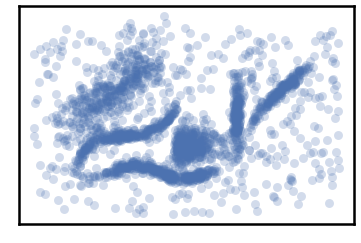

In [2]:
data = np.load('clusterable_data.npy')
plt.scatter(data.T[0], data.T[1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

In [3]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

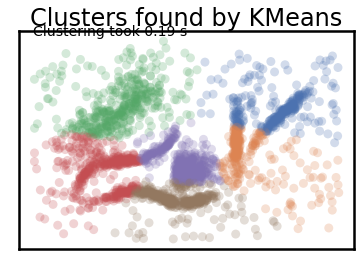

In [4]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters':6})

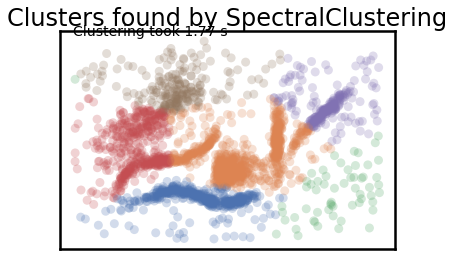

In [5]:
plot_clusters(data, cluster.SpectralClustering, (), {'n_clusters':6})


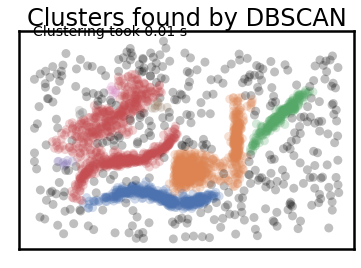

In [9]:
plot_clusters(data, cluster.DBSCAN, (), {'eps':0.025})

In [ ]:
#import hdbscan
#plot_clusters(data, cluster.hbscan, (), {'eps':0.025})

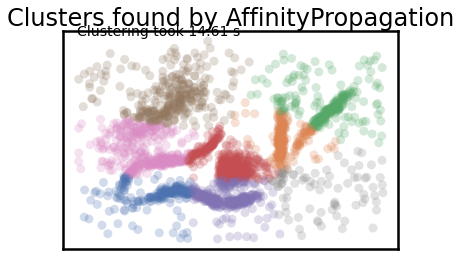

In [10]:
plot_clusters(data, cluster.AffinityPropagation, (), 
              {
    'preference':-5.0, 
    'damping':0.95
})


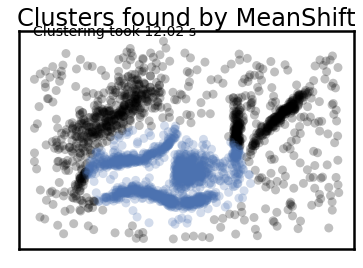

In [15]:
plot_clusters(data, cluster.MeanShift, (), {'cluster_all':False})


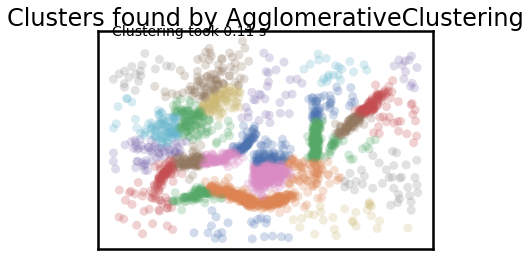

In [16]:
plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':26, 'linkage':'ward'})


In [12]:
cluster.MeanShift?

Init signature:
cluster.MeanShift(
    *,
    bandwidth=None,
    seeds=None,
    bin_seeding=False,
    min_bin_freq=1,
    cluster_all=True,
    n_jobs=None,
    max_iter=300,
)
Docstring:     
Mean shift clustering using a flat kernel.

Mean shift clustering aims to discover "blobs" in a smooth density of
samples. It is a centroid-based algorithm, which works by updating
candidates for centroids to be the mean of the points within a given
region. These candidates are then filtered in a post-processing stage to
eliminate near-duplicates to form the final set of centroids.

Seeding is performed using a binning technique for scalability.

Read more in the :ref:`User Guide <mean_shift>`.

Parameters
----------
bandwidth : float, default=None
    Bandwidth used in the RBF kernel.

    If not given, the bandwidth is estimated using
    sklearn.cluster.estimate_bandwidth; see the documentation for that
    function for hints on scalability (see also the Notes, below).

seeds : array-like o


# Detail Comparison of different clustering algorithms on toy datasets
---

This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.



Automatically created module for IPython interactive environment


C:\Users\andre\anaconda3\envs\pypbix\lib\site-packages\ipykernel_launcher.py:151: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\andre\anaconda3\envs\pypbix\lib\site-packages\ipykernel_launcher.py:151: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

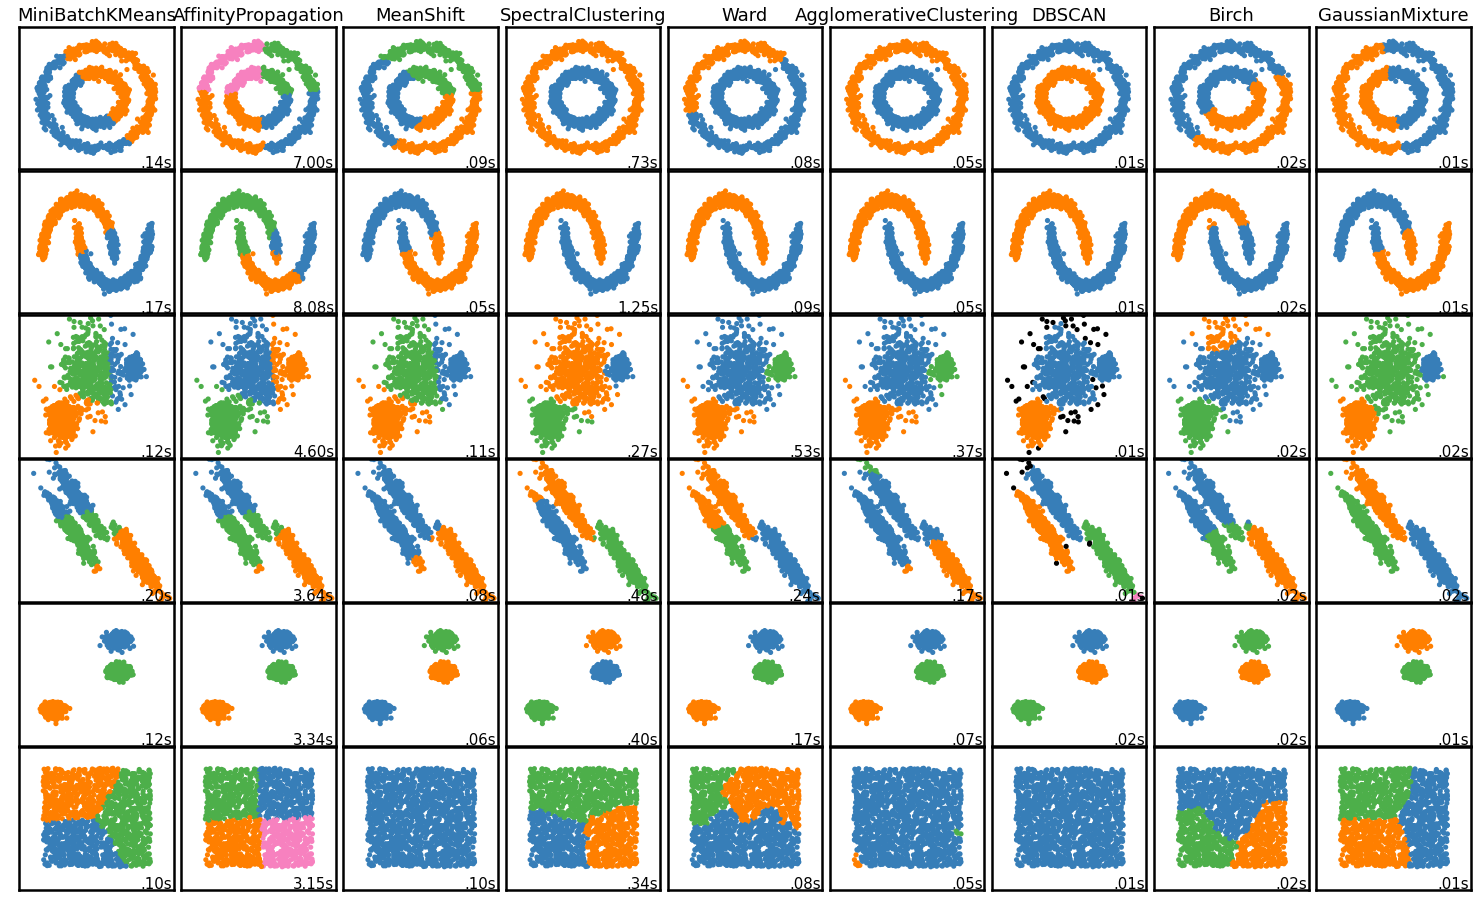

In [17]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])

    
    #     optics = cluster.OPTICS(min_samples=params['min_samples'],
#                             xi=params['xi'],
#                             min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        #('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

<h9>[simple source](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)
[complex source](
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html)</h9>